# 分心驾驶数据分析

训练一个神经网络分类器，对分析驾驶数据进行分类和预测。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 加载和准备数据


### 读取数据
从data.excle文件中读取所有Sheet的数据，一共有8个Sheets。

In [340]:
data_path = "data.xlsx"
         
raw_data = pd.read_excel(data_path, None)
n_classes = 2

In [341]:
print "excel data has {:d} sheets:".format(len(raw_data))
for name in raw_data.keys():
    print "\t {:} has {:d} rows and {:d} colums".format(name, raw_data[name].shape[0], raw_data[name].shape[1])

excel data has 8 sheets:
	 Sheet1 has 180 rows and 4 colums
	 Sheet2 has 180 rows and 4 colums
	 Sheet6 has 180 rows and 4 colums
	 Sheet3 has 180 rows and 4 colums
	 Sheet9 has 180 rows and 4 colums
	 Sheet5 has 180 rows and 4 colums
	 Sheet7 has 180 rows and 4 colums
	 Sheet4 has 180 rows and 4 colums


In [342]:
k = raw_data.keys()
raw_data[k[7]].head()

,事项,方向盘转角标准差,事项.1,方向盘转角标准差.1
0,平稳行驶1,0.0373,饮水驾驶次任务1,0.0160
1,平稳行驶2,0.0277,饮水驾驶次任务2,0.0177
2,平稳行驶3,0.0103,饮水驾驶次任务3,0.0383
3,平稳行驶4,0.0382,饮水驾驶次任务4,0.0147
4,平稳行驶5,0.0248,饮水驾驶次任务5,0.0120


### 数据简介、数据整理
将所有的特征提取、整理到一起，并生成相应标签。从上面可以看出，一共有8个Sheet, 并且Sheet的名字并不是从1-8的顺序，有点乱，8个sheet的内容分别是：

    车速离差  
    车速标准插  
    平均加速度  
    加速度标准差   
    平均油门踏板角度  
    油门踏板标准差  
    方向盘平均转角   
    方向盘转角标准差  
    
每个Sheet的结构是一致的，平稳驾驶和饮水驾驶的数据各占1列，并且数量都是180，因此将数据整理成如下格式：

    speed_bias speed_std acc_mean acc_std  penal_mean penal_std wheel_mean wheel_std  label

其中label的取值：

    1：分心驾驶
    0：平稳驾驶
                                                                                    
       

In [343]:
#从每个sheet里提取出来第2、4列
frames = [raw_data[name].iloc[:, [1,3]] for name in raw_data.keys()]

#将两列合并成一列
frames = [pd.concat([f.iloc[:,0], f.iloc[:,1]], axis=0, ignore_index=True) for f in frames ]

#合并所有的特征到一张表里
all_data = pd.concat(frames, axis = 1)

#增加label
labels = np.ones(len(all_data), dtype=np.int32)
labels[:len(labels)/2] = 0
all_data[-1] = labels

#修改colum名称
feature_names = ['speed_bias', 'speed_std', 'acc_mean', 'acc_std',  'penal_mean', 'penal_std', \
                  'wheel_mean', 'wheel_std',  'label']
colums = list(all_data.columns)
name_dict = {old:new for old,new in zip(colums, feature_names)}
all_data = all_data.rename(index = str, columns = name_dict)

In [344]:
all_data.head()

,speed_bias,speed_std,acc_mean,acc_std,penal_mean,penal_std,wheel_mean,wheel_std,label
0,0.23963,1.1814,-0.0033,0.3334,-0.007535,0.0473,0.1062,0.0373,0
1,0.13603,1.1085,0.0084,0.2059,-0.001735,0.0299,0.1190,0.0277,0
2,0.15033,0.5997,-0.0019,0.0748,0.002765,0.0114,0.1341,0.0103,0
3,0.18873,0.8835,-0.0131,0.1834,-0.017635,0.0272,0.0760,0.0382,0
4,0.38433,1.2829,0.0179,0.1849,0.002065,0.0285,0.1234,0.0248,0


### 数据简介

此数据集包括了平稳驾驶、饮水驾驶各180次的数据，数据特征为车速标准差(speed)、加速度标准差(acc)、方向盘转角标准差(wheel)、油门踏板标准差(pedal)。改变上方的索引，可以看到不同特征前几行的数据。

下图绘制出了各特征的正负样本分布图。

NameError: name 'name_to_sheet' is not defined

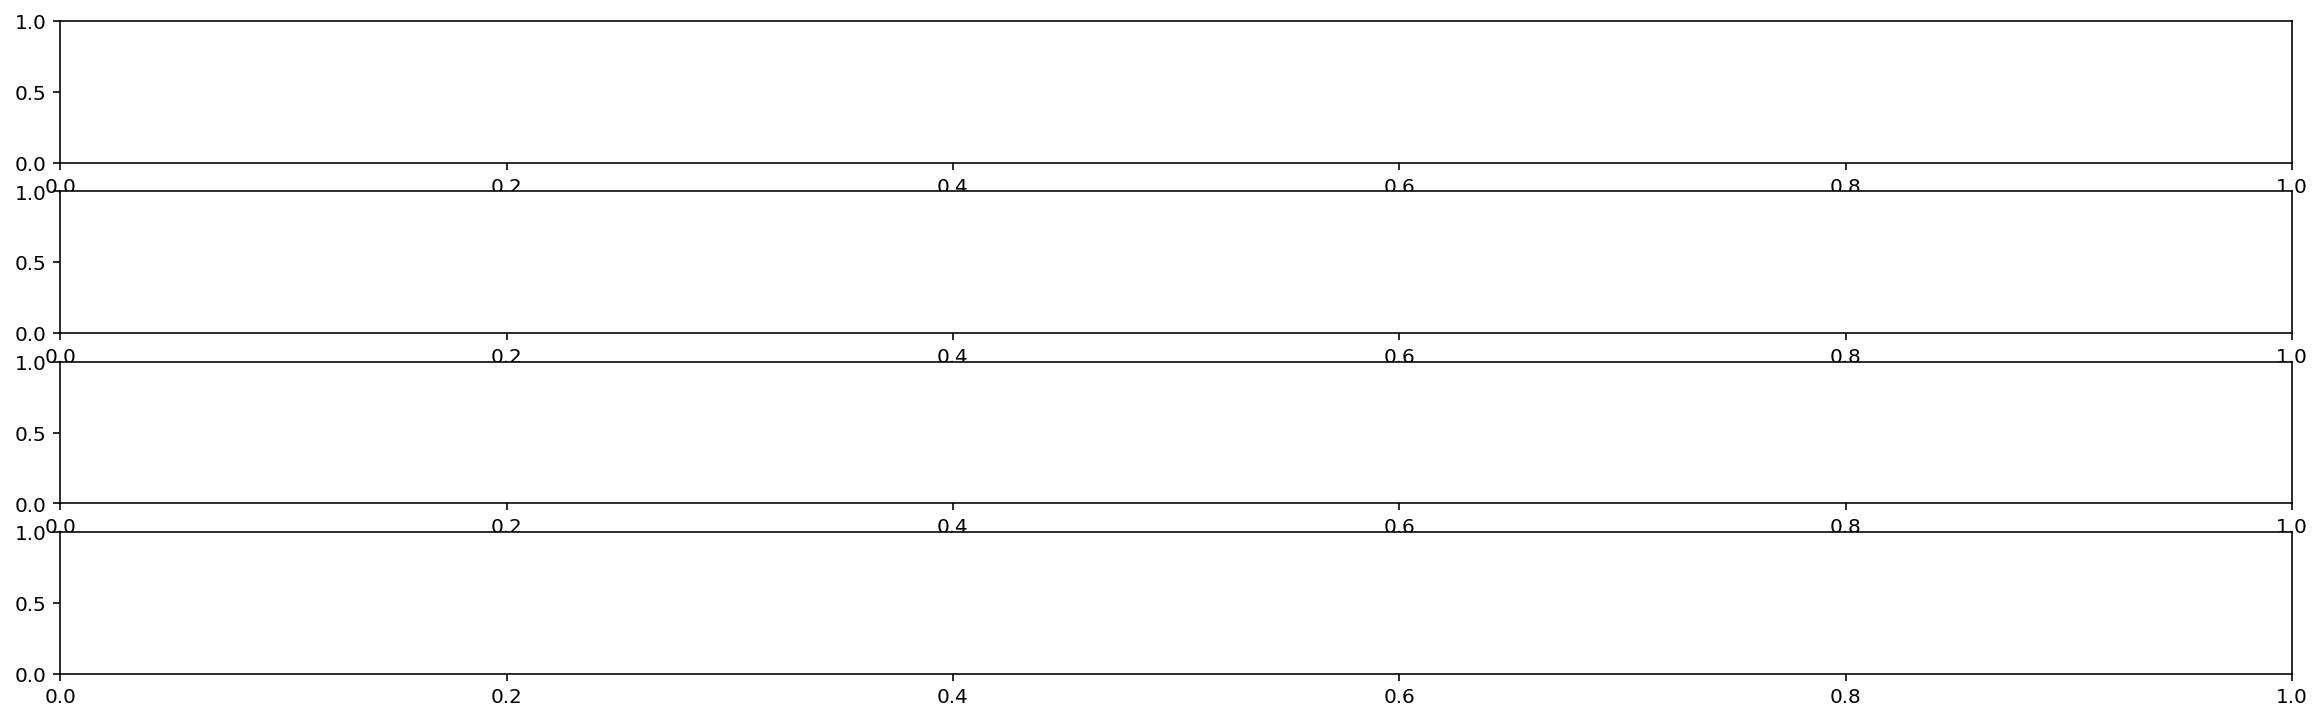

In [79]:
fig, ax = plt.subplots(4,1,figsize=(20,6))

index = name_to_sheet['speed']
frame = deviation[index]
col = frame.columns
ax[0].plot(frame.index, frame[col[1]])
ax[0].plot(frame.index, frame[col[3]])

index = name_to_sheet['acc']
frame = deviation[index]
col = frame.columns
ax[1].scatter(frame.index, frame[col[1]])
ax[1].scatter(frame.index, frame[col[3]])

index = name_to_sheet['wheel']
frame = deviation[index]
col = frame.columns
ax[2].scatter(frame.index, frame[col[1]])
ax[2].scatter(frame.index, frame[col[3]])

index = name_to_sheet['pedal']
frame = deviation[index]
col = frame.columns
ax[3].scatter(frame.index, frame[col[1]])
ax[3].scatter(frame.index, frame[col[3]])

### 调整目标变量

为了更轻松地训练网络，对每个连续变量标准化，即转换和调整变量，使它们的均值为 0，标准差为 1。

我们会保存换算因子，以便当我们使用网络进行预测时可以还原数据。

In [223]:
# Store scalings in a dictionary so we can convert back later
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
all_features = scaler.fit_transform(all_data.drop('label', axis = 1))
all_labels = all_data['label'].values

In [224]:
all_features

array([[ 0.61441597,  0.09833512,  0.35493827, ...,  0.11549986,
         0.85231934,  0.27242798],
       [ 0.60738207,  0.09044884,  0.38271605, ...,  0.06810133,
         0.89271063,  0.19341564],
       [ 0.60835296,  0.03540713,  0.35826211, ...,  0.01770635,
         0.94035973,  0.05020576],
       ..., 
       [ 0.49453888,  0.34286394,  0.24192783, ...,  0.3522201 ,
         0.90943515,  0.22716049],
       [ 0.74166235,  0.36391566,  0.43708452, ...,  0.28684282,
         0.80656358,  0.38106996],
       [ 0.63960969,  0.32026526,  0.17545109, ...,  0.37401253,
         0.97317766,  0.18930041]])

### 特征选择

In [324]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#选择K个最好的特征，返回选择特征后的数据
selector = SelectKBest(chi2, k=8)
selected_features = selector.fit_transform(all_features, all_labels)

In [325]:
selector.scores_

array([  4.16092015e-04,   1.31174479e+01,   3.37445207e-01,
         1.27018179e+01,   6.43914177e-09,   9.44482098e+00,
         2.91332747e-02,   8.44811203e-01])

### 将数据拆分为训练、测试和验证数据集



In [326]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(selected_features, all_labels, test_size=0.2, random_state=3)

In [327]:
len(X_test)

72

# 评价指标

## 开始训练
  

### SVM


In [328]:
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

clf = SVC(C=10, kernel='linear')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.79166666666666663

In [329]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import KFold

clf = DecisionTreeClassifier(max_depth= 10)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.84722222222222221

In [330]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.84722222222222221

In [331]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.83333333333333337

## 参数优化

In [332]:
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier()
para = {'max_depth':[i for i in range(1,100)]}

grid_clf = GridSearchCV(clf, para, cv=10)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [336]:
from sklearn.model_selection import GridSearchCV

clf = SVC()
arr = [i for i in range(1,20)]
para = {'kernel':['linear', 'rbf'], 'C':arr}

grid_clf = GridSearchCV(clf, para, cv=10)
grid_clf.fit(X_train, y_train)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear', 'rbf'], 'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [337]:
grid_clf.best_score_

0.85763888888888884

In [338]:
grid_clf.best_params_

{'C': 15, 'kernel': 'linear'}

In [339]:
grid_clf.score(X_test, y_test)

0.79166666666666663

## 检查预测结果

使用测试数据看看网络对数据建模的效果如何。如果完全错了，请确保网络中的每步都正确实现。

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)